### Step 1: Initial Setup and Data Loading

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 1.26.4


### Step 2: Load Historical Fights and Fighter Profiles

In [2]:
# Load historical fights data
fights_df = pd.read_csv('historical_fights.csv')

# Load fighter profiles
with open('fighter_profiles.json', 'r') as f:
    fighter_profiles = json.load(f)

with open('enhanced_fighter_profiles.json', 'r') as f:
    enhanced_profiles = json.load(f)

# Display basic information
print("=" * 80)
print("HISTORICAL FIGHTS DATA")
print("=" * 80)
print(f"Shape: {fights_df.shape}")
print(f"\nColumns: {list(fights_df.columns)}")
print(f"\nFirst few rows:")
print(fights_df.head())
print(f"\nData types:")
print(fights_df.dtypes)
print(f"\nMissing values:")
print(fights_df.isnull().sum())

print("\n" + "=" * 80)
print("FIGHTER PROFILES")
print("=" * 80)
print(f"Number of fighters in basic profiles: {len(fighter_profiles)}")
print(f"Number of fighters in enhanced profiles: {len(enhanced_profiles)}")

# Show sample fighter profile
sample_fighter = list(fighter_profiles.keys())[0]
print(f"\nSample fighter profile ({sample_fighter}):")
print(json.dumps(fighter_profiles[sample_fighter], indent=2))

HISTORICAL FIGHTS DATA
Shape: (7378, 42)

Columns: ['event_name', 'event_date', 'event_id', 'match_id', 'match_date', 'match_time', 'status', 'localteam_name', 'localteam_id', 'localteam_winner', 'awayteam_name', 'awayteam_id', 'awayteam_winner', 'win_type', 'win_round', 'win_minute', 'ko_type', 'ko_target', 'sub_type', 'points_score', 'local_strikes_head', 'local_strikes_body', 'local_strikes_legs', 'local_power_head', 'local_power_body', 'local_power_legs', 'local_takedowns_att', 'local_takedowns_landed', 'local_submissions', 'local_control_time', 'local_knockdowns', 'away_strikes_head', 'away_strikes_body', 'away_strikes_legs', 'away_power_head', 'away_power_body', 'away_power_legs', 'away_takedowns_att', 'away_takedowns_landed', 'away_submissions', 'away_control_time', 'away_knockdowns']

First few rows:
                 event_name  event_date  event_id  match_id  match_date  \
0  UFC 108: Evans vs. Silva  02.01.2010     93084     93085  02.01.2010   
1  UFC 108: Evans vs. Silva  0

## Step 3: Exploratory Data Analysis

In [3]:
# Basic statistics about fights
print("=" * 80)
print("FIGHT OUTCOME ANALYSIS")
print("=" * 80)

# Win type distribution
print("\nWin Type Distribution:")
print(fights_df['win_type'].value_counts())
print(f"\nWin Type Percentages:")
print(fights_df['win_type'].value_counts(normalize=True) * 100)

# Check data quality
print("\n" + "=" * 80)
print("DATA QUALITY CHECKS")
print("=" * 80)

# Date range
print(f"\nDate Range: {fights_df['event_date'].min()} to {fights_df['event_date'].max()}")
print(f"Total Fights: {len(fights_df)}")
print(f"Unique Fighters: {len(set(list(fights_df['localteam_id']) + list(fights_df['awayteam_id'])))}")

# Check for any data inconsistencies
print("\n" + "=" * 80)
print("SAMPLE FIGHTER PROFILE KEYS")
print("=" * 80)
sample_enhanced = list(enhanced_profiles.keys())[0]
print(f"\nEnhanced profile keys for fighter {sample_enhanced}:")
print(json.dumps(enhanced_profiles[sample_enhanced], indent=2)[:1000] + "...")

# Distribution of rounds
print("\n" + "=" * 80)
print("ROUND STATISTICS")
print("=" * 80)
print(fights_df['win_round'].value_counts().sort_index())

FIGHT OUTCOME ANALYSIS

Win Type Distribution:
win_type
Points                           2798
KO                               2257
SUB                              1333
S Dec                             724
No Contest                         80
TKO - Dr                           65
M Dec                              48
Draw                               43
DQ                                 18
M Draw                              6
CNC                                 3
Decision - Split (Draw)             1
Overturned                          1
Submission (Rear Naked Choke)       1
Name: count, dtype: int64

Win Type Percentages:
win_type
Points                           37.923557
KO                               30.590946
SUB                              18.067227
S Dec                             9.812957
No Contest                        1.084305
TKO - Dr                          0.880998
M Dec                             0.650583
Draw                              0.582814
DQ        

## Step 4: Data Preparation and Feature Engineering

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Create a copy for processing
df = fights_df.copy()

# Convert dates to datetime
df['event_date'] = pd.to_datetime(df['event_date'], format='%d.%m.%Y')
df['match_date'] = pd.to_datetime(df['match_date'], format='%d.%m.%Y')

# Sort by date to maintain temporal order
df = df.sort_values('event_date').reset_index(drop=True)

print("=" * 80)
print("STEP 1: BASIC DATA PREPARATION")
print("=" * 80)
print(f"Data sorted by date: {df['event_date'].min()} to {df['event_date'].max()}")

# Consolidate win types into main categories for easier prediction
def consolidate_win_type(win_type):
    win_type = str(win_type).upper()
    if 'KO' in win_type or 'TKO' in win_type:
        return 'KO'
    elif 'SUB' in win_type:
        return 'SUB'
    elif 'POINTS' in win_type or 'DEC' in win_type or 'DECISION' in win_type:
        return 'DEC'
    elif 'DRAW' in win_type:
        return 'DRAW'
    elif 'NO CONTEST' in win_type or 'CNC' in win_type or 'OVERTURNED' in win_type:
        return 'NC'
    elif 'DQ' in win_type:
        return 'DQ'
    else:
        return 'OTHER'

df['win_type_consolidated'] = df['win_type'].apply(consolidate_win_type)

print("\nConsolidated Win Types:")
print(df['win_type_consolidated'].value_counts())
print(f"\nPercentages:")
print(df['win_type_consolidated'].value_counts(normalize=True) * 100)

# Create target variables
# Target 1: Winner (1 = localteam wins, 0 = awayteam wins)
df['target_winner'] = df['localteam_winner'].astype(int)

# Target 2: Win type (consolidated)
df['target_win_type'] = df['win_type_consolidated']

print("\n" + "=" * 80)
print("TARGET VARIABLES CREATED")
print("=" * 80)
print(f"Winner distribution:\n{df['target_winner'].value_counts()}")
print(f"\nWin type distribution:\n{df['target_win_type'].value_counts()}")

STEP 1: BASIC DATA PREPARATION
Data sorted by date: 2010-01-02 00:00:00 to 2025-11-22 00:00:00

Consolidated Win Types:
win_type_consolidated
DEC     3571
KO      2322
SUB     1334
NC        84
DRAW      49
DQ        18
Name: count, dtype: int64

Percentages:
win_type_consolidated
DEC     48.400651
KO      31.471944
SUB     18.080781
NC       1.138520
DRAW     0.664137
DQ       0.243969
Name: proportion, dtype: float64

TARGET VARIABLES CREATED
Winner distribution:
target_winner
0    4099
1    3279
Name: count, dtype: int64

Win type distribution:
target_win_type
DEC     3571
KO      2322
SUB     1334
NC        84
DRAW      49
DQ        18
Name: count, dtype: int64


## Step 5: Feature Engineering from Fighter Profiles

In [5]:
def get_fighter_features(fighter_id, profiles, enhanced_profiles, fight_date=None):
    """
    Extract features from fighter profiles at a given point in time.
    """
    fighter_id = str(fighter_id)
    features = {}
    
    # Check if fighter exists in profiles
    if fighter_id not in profiles or fighter_id not in enhanced_profiles:
        return None
    
    profile = profiles[fighter_id]
    enhanced = enhanced_profiles[fighter_id]
    
    # ===== RECORD FEATURES =====
    record = profile.get('record', {})
    features['wins'] = record.get('wins', 0)
    features['losses'] = record.get('losses', 0)
    features['draws'] = record.get('draws', 0)
    features['total_fights'] = features['wins'] + features['losses'] + features['draws']
    features['win_pct'] = record.get('win_pct', 0)
    
    # Win method distribution
    win_methods = profile.get('win_methods', {})
    features['ko_wins_pct'] = win_methods.get('KO_pct', 0)
    features['sub_wins_pct'] = win_methods.get('SUB_pct', 0)
    features['dec_wins_pct'] = win_methods.get('DEC_pct', 0)
    
    # Loss method distribution
    loss_methods = profile.get('loss_methods', {})
    total_losses = sum([loss_methods.get(k, 0) for k in ['KO', 'SUB', 'DEC', 'OTHER']])
    features['ko_losses'] = loss_methods.get('KO', 0)
    features['sub_losses'] = loss_methods.get('SUB', 0)
    features['dec_losses'] = loss_methods.get('DEC', 0)
    
    # ===== STRIKING FEATURES =====
    striking = profile.get('striking', {})
    features['slpm'] = striking.get('slpm', 0)  # Strikes landed per minute
    features['sapm'] = striking.get('sapm', 0)  # Strikes absorbed per minute
    features['strike_differential'] = features['slpm'] - features['sapm']
    
    features['total_strikes_landed'] = striking.get('total_landed', 0)
    features['total_strikes_absorbed'] = striking.get('total_absorbed', 0)
    
    features['head_landed_avg'] = striking.get('avg_head_landed', 0)
    features['body_landed_avg'] = striking.get('avg_body_landed', 0)
    features['legs_landed_avg'] = striking.get('avg_legs_landed', 0)
    
    features['power_head_landed'] = striking.get('power_head_landed', 0)
    features['power_body_landed'] = striking.get('power_body_landed', 0)
    features['power_legs_landed'] = striking.get('power_legs_landed', 0)
    
    # ===== GRAPPLING FEATURES =====
    grappling = profile.get('grappling', {})
    features['td_accuracy'] = grappling.get('td_accuracy', 0)
    features['td_avg_15m'] = grappling.get('td_avg_15m', 0)
    features['sub_avg_15m'] = grappling.get('sub_avg_15m', 0)
    features['takedowns_landed'] = grappling.get('takedowns_landed', 0)
    features['takedowns_attempts'] = grappling.get('takedowns_attempts', 0)
    features['submissions_attempts'] = grappling.get('submissions_attempts', 0)
    
    # ===== ENHANCED PROFILE FEATURES =====
    features['height_inches'] = enhanced.get('height_inches', 0) or 0
    features['reach_inches'] = enhanced.get('reach_inches', 0) or 0
    features['age'] = enhanced.get('age', 0) or 0
    
    # Stance encoding (1=Orthodox, 0=Southpaw, -1=Unknown/Other)
    stance = enhanced.get('stance', '').lower()
    if 'orthodox' in stance:
        features['stance'] = 1
    elif 'southpaw' in stance:
        features['stance'] = 0
    else:
        features['stance'] = -1
    
    # Enhanced striking stats
    enhanced_strikes = enhanced.get('strikes', {})
    features['total_landed_avg'] = enhanced_strikes.get('total_landed_avg', 0)
    features['total_absorbed_avg'] = enhanced_strikes.get('total_absorbed_avg', 0)
    features['head_ratio'] = enhanced_strikes.get('head_ratio', 0)
    features['body_ratio'] = enhanced_strikes.get('body_ratio', 0)
    features['legs_ratio'] = enhanced_strikes.get('legs_ratio', 0)
    
    # Enhanced grappling
    enhanced_grappling = enhanced.get('grappling', {})
    features['td_landed_avg'] = enhanced_grappling.get('td_landed_avg', 0)
    features['td_attempted_avg'] = enhanced_grappling.get('td_attempted_avg', 0)
    features['td_absorbed_avg'] = enhanced_grappling.get('td_absorbed_avg', 0)
    
    # Fight experience
    features['fight_time_seconds'] = profile.get('fight_time_seconds', 0)
    
    return features

# Test feature extraction
print("=" * 80)
print("TESTING FEATURE EXTRACTION")
print("=" * 80)

sample_fighter_id = df.iloc[0]['localteam_id']
sample_features = get_fighter_features(sample_fighter_id, fighter_profiles, enhanced_profiles)

print(f"\nSample features for fighter {sample_fighter_id}:")
for key, value in list(sample_features.items())[:15]:
    print(f"  {key}: {value}")
print(f"\n... Total features extracted: {len(sample_features)}")

TESTING FEATURE EXTRACTION

Sample features for fighter 92903:
  wins: 8
  losses: 5
  draws: 0
  total_fights: 13
  win_pct: 61.5
  ko_wins_pct: 50.0
  sub_wins_pct: 0.0
  dec_wins_pct: 50.0
  ko_losses: 2
  sub_losses: 2
  dec_losses: 1
  slpm: 4.95
  sapm: 4.44
  strike_differential: 0.5099999999999998
  total_strikes_landed: 643

... Total features extracted: 41


## Step 6: Create Full Feature Matrix

In [6]:
def create_fight_features(row, profiles, enhanced_profiles):
    """
    Create features for a single fight by combining both fighters' stats.
    """
    local_id = row['localteam_id']
    away_id = row['awayteam_id']
    
    # Get features for both fighters
    local_features = get_fighter_features(local_id, profiles, enhanced_profiles)
    away_features = get_fighter_features(away_id, profiles, enhanced_profiles)
    
    # If either fighter doesn't have profile data, skip this fight
    if local_features is None or away_features is None:
        return None
    
    fight_features = {}
    
    # Add local fighter features with prefix
    for key, value in local_features.items():
        fight_features[f'local_{key}'] = value
    
    # Add away fighter features with prefix
    for key, value in away_features.items():
        fight_features[f'away_{key}'] = value
    
    # Create differential features (local - away)
    for key in local_features.keys():
        fight_features[f'diff_{key}'] = local_features[key] - away_features[key]
    
    # Add fight-level features from the row
    fight_features['win_round'] = row['win_round']
    
    return fight_features

print("=" * 80)
print("CREATING FEATURE MATRIX FOR ALL FIGHTS")
print("=" * 80)

# Create features for all fights
feature_list = []
valid_indices = []

print("Processing fights...")
for idx, row in df.iterrows():
    if idx % 1000 == 0:
        print(f"  Processed {idx}/{len(df)} fights...")
    
    features = create_fight_features(row, fighter_profiles, enhanced_profiles)
    if features is not None:
        feature_list.append(features)
        valid_indices.append(idx)

print(f"\nCompleted! Valid fights with features: {len(feature_list)}/{len(df)}")

# Create feature dataframe
X = pd.DataFrame(feature_list)
print(f"\nFeature matrix shape: {X.shape}")
print(f"Total features created: {X.shape[1]}")

# Get corresponding targets
y_winner = df.loc[valid_indices, 'target_winner'].values
y_win_type = df.loc[valid_indices, 'target_win_type'].values

print(f"\nTarget shapes:")
print(f"  y_winner: {y_winner.shape}")
print(f"  y_win_type: {y_win_type.shape}")

# Show sample of features
print("\n" + "=" * 80)
print("SAMPLE FEATURES")
print("=" * 80)
print(X.head())

print("\n" + "=" * 80)
print("FEATURE STATISTICS")
print("=" * 80)
print(X.describe())

CREATING FEATURE MATRIX FOR ALL FIGHTS
Processing fights...
  Processed 0/7378 fights...
  Processed 1000/7378 fights...
  Processed 2000/7378 fights...
  Processed 3000/7378 fights...
  Processed 4000/7378 fights...
  Processed 5000/7378 fights...
  Processed 6000/7378 fights...
  Processed 7000/7378 fights...

Completed! Valid fights with features: 7378/7378

Feature matrix shape: (7378, 124)
Total features created: 124

Target shapes:
  y_winner: (7378,)
  y_win_type: (7378,)

SAMPLE FEATURES
   local_wins  local_losses  local_draws  local_total_fights  local_win_pct  \
0           8             5            0                  13           61.5   
1           9             8            0                  17           52.9   
2           2             5            0                   7           28.6   
3           6             3            0                   9           66.7   
4           6             7            1                  14           42.9   

   local_ko_wins_pct  lo

## Step 7: Data Cleaning and Train/Test Split

In [7]:
# Check for any missing or infinite values
print("=" * 80)
print("CHECKING DATA QUALITY")
print("=" * 80)

# Check for NaN or inf values
print(f"\nMissing values in features: {X.isnull().sum().sum()}")
print(f"Infinite values in features: {np.isinf(X).sum().sum()}")

# Replace any inf with NaN and then fill with 0
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

print(f"After cleaning - Missing values: {X.isnull().sum().sum()}")
print(f"After cleaning - Infinite values: {np.isinf(X).sum().sum()}")

# Remove problematic target classes (NC, DRAW, DQ) for win type prediction
# We'll focus on the main three: KO, SUB, DEC
main_win_types = ['KO', 'SUB', 'DEC']
mask = pd.Series(y_win_type).isin(main_win_types)

X_clean = X[mask].reset_index(drop=True)
y_winner_clean = y_winner[mask]
y_win_type_clean = y_win_type[mask]

print("\n" + "=" * 80)
print("FILTERED DATA FOR MAIN WIN TYPES")
print("=" * 80)
print(f"Original samples: {len(X)}")
print(f"Filtered samples: {len(X_clean)}")
print(f"Win type distribution after filtering:")
print(pd.Series(y_win_type_clean).value_counts())

# Temporal split (80/20) to avoid data leakage
# We'll use chronological split based on the original dataframe
split_idx = int(len(X_clean) * 0.8)

X_train = X_clean.iloc[:split_idx]
X_test = X_clean.iloc[split_idx:]

y_winner_train = y_winner_clean[:split_idx]
y_winner_test = y_winner_clean[split_idx:]

y_win_type_train = y_win_type_clean[:split_idx]
y_win_type_test = y_win_type_clean[split_idx:]

print("\n" + "=" * 80)
print("TRAIN/TEST SPLIT (TEMPORAL)")
print("=" * 80)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining winner distribution:")
print(pd.Series(y_winner_train).value_counts())
print(f"\nTraining win type distribution:")
print(pd.Series(y_win_type_train).value_counts())

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n" + "=" * 80)
print("FEATURE SCALING COMPLETE")
print("=" * 80)
print(f"Training features scaled: {X_train_scaled.shape}")
print(f"Test features scaled: {X_test_scaled.shape}")
print("\nData preparation complete! Ready for modeling.")

CHECKING DATA QUALITY

Missing values in features: 0
Infinite values in features: 0
After cleaning - Missing values: 0
After cleaning - Infinite values: 0

FILTERED DATA FOR MAIN WIN TYPES
Original samples: 7378
Filtered samples: 7227
Win type distribution after filtering:
DEC    3571
KO     2322
SUB    1334
Name: count, dtype: int64

TRAIN/TEST SPLIT (TEMPORAL)
Training set: 5781 samples
Test set: 1446 samples

Training winner distribution:
0    3141
1    2640
Name: count, dtype: int64

Training win type distribution:
DEC    2826
KO     1878
SUB    1077
Name: count, dtype: int64

FEATURE SCALING COMPLETE
Training features scaled: (5781, 124)
Test features scaled: (1446, 124)

Data preparation complete! Ready for modeling.


## Step 8: Model 1 - Winner Prediction with Probabilities

In [8]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import seaborn as sns

print("=" * 80)
print("MODEL 1: WINNER PREDICTION")
print("=" * 80)

# Train multiple models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=15, 
                                           random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, max_depth=5,
                                                    learning_rate=0.1, random_state=42)
}

results_winner = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    print('='*60)
    
    # Train
    model.fit(X_train_scaled, y_winner_train)
    
    # Predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Probabilities
    y_prob_train = model.predict_proba(X_train_scaled)[:, 1]
    y_prob_test = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    train_acc = accuracy_score(y_winner_train, y_pred_train)
    test_acc = accuracy_score(y_winner_test, y_pred_test)
    train_auc = roc_auc_score(y_winner_train, y_prob_train)
    test_auc = roc_auc_score(y_winner_test, y_prob_test)
    
    results_winner[name] = {
        'model': model,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'train_auc': train_auc,
        'test_auc': test_auc,
        'y_pred_test': y_pred_test,
        'y_prob_test': y_prob_test
    }
    
    print(f"\nTraining Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Training AUC: {train_auc:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    
    print(f"\nTest Set Classification Report:")
    print(classification_report(y_winner_test, y_pred_test, 
                                target_names=['Away Team Wins', 'Local Team Wins']))

# Compare models
print("\n" + "=" * 80)
print("MODEL COMPARISON - WINNER PREDICTION")
print("=" * 80)
comparison_df = pd.DataFrame({
    'Model': list(results_winner.keys()),
    'Train Accuracy': [r['train_acc'] for r in results_winner.values()],
    'Test Accuracy': [r['test_acc'] for r in results_winner.values()],
    'Train AUC': [r['train_auc'] for r in results_winner.values()],
    'Test AUC': [r['test_auc'] for r in results_winner.values()]
})
print(comparison_df.to_string(index=False))

# Select best model
best_model_name = max(results_winner.keys(), 
                      key=lambda x: results_winner[x]['test_auc'])
best_winner_model = results_winner[best_model_name]['model']

print(f"\n✓ Best Model: {best_model_name}")
print(f"  Test Accuracy: {results_winner[best_model_name]['test_acc']:.4f}")
print(f"  Test AUC: {results_winner[best_model_name]['test_auc']:.4f}")

MODEL 1: WINNER PREDICTION

Training Logistic Regression...

Training Accuracy: 0.7935
Test Accuracy: 0.8077
Training AUC: 0.8830
Test AUC: 0.8957

Test Set Classification Report:
                 precision    recall  f1-score   support

 Away Team Wins       0.81      0.87      0.84       817
Local Team Wins       0.81      0.73      0.77       629

       accuracy                           0.81      1446
      macro avg       0.81      0.80      0.80      1446
   weighted avg       0.81      0.81      0.81      1446


Training Random Forest...

Training Accuracy: 0.9969
Test Accuracy: 0.8022
Training AUC: 0.9999
Test AUC: 0.8730

Test Set Classification Report:
                 precision    recall  f1-score   support

 Away Team Wins       0.81      0.85      0.83       817
Local Team Wins       0.79      0.74      0.76       629

       accuracy                           0.80      1446
      macro avg       0.80      0.79      0.80      1446
   weighted avg       0.80      0.80     

## Step 9: Feature Importance Analysis

FEATURE IMPORTANCE - TOP 20 FEATURES
                    feature  importance
               diff_win_pct    0.509217
          diff_dec_wins_pct    0.027760
    diff_fight_time_seconds    0.023224
                  win_round    0.021733
           diff_ko_wins_pct    0.010386
    diff_total_absorbed_avg    0.008464
diff_total_strikes_absorbed    0.008267
          away_dec_wins_pct    0.007574
          diff_sub_wins_pct    0.007557
     diff_power_head_landed    0.007473
  diff_total_strikes_landed    0.007446
           diff_td_accuracy    0.007282
     diff_power_legs_landed    0.007089
              local_win_pct    0.006420
                  diff_sapm    0.006289
             diff_ko_losses    0.005921
            diff_dec_losses    0.005913
   diff_strike_differential    0.005882
                  diff_slpm    0.005831
    away_fight_time_seconds    0.005670


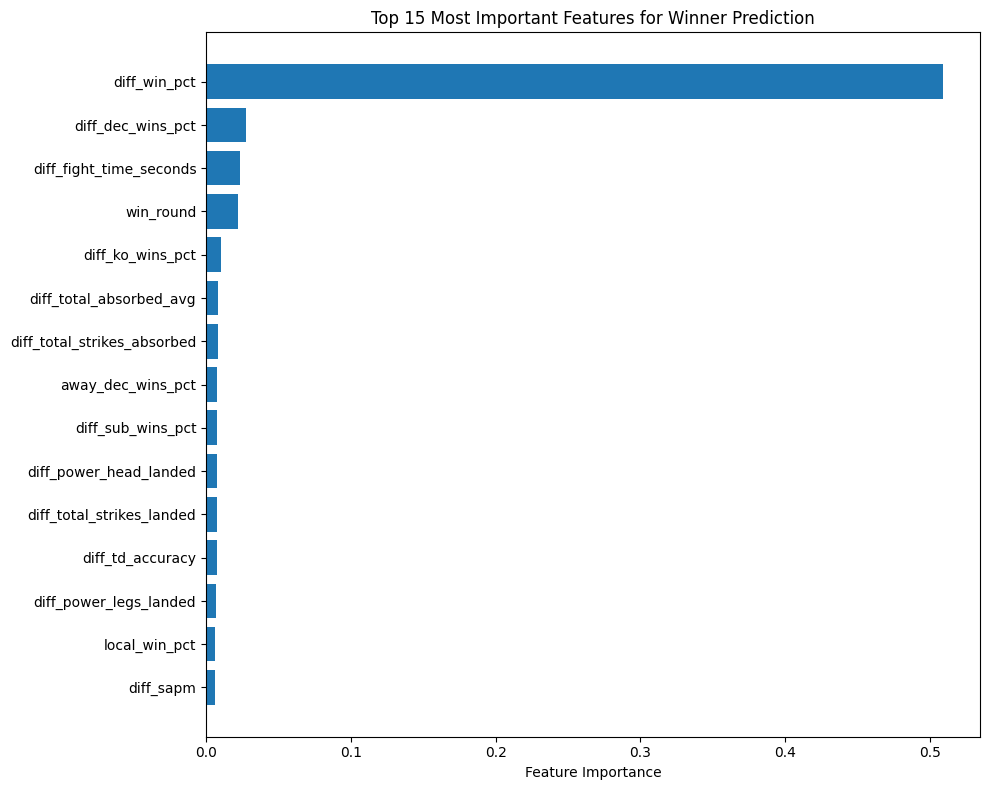


SAMPLE PREDICTIONS WITH PROBABILITIES

Actual     Predicted  Probability     Correct   
--------------------------------------------------
AWAY       AWAY       0.9126          ✓         
AWAY       AWAY       0.8853          ✓         
LOCAL      LOCAL      0.9699          ✓         
AWAY       AWAY       0.8445          ✓         
LOCAL      LOCAL      0.8707          ✓         
AWAY       AWAY       0.9976          ✓         
LOCAL      AWAY       0.8418          ✗         
LOCAL      LOCAL      0.8963          ✓         
AWAY       AWAY       0.9950          ✓         
AWAY       AWAY       0.9461          ✓         


In [9]:
# Feature importance for Gradient Boosting
print("=" * 80)
print("FEATURE IMPORTANCE - TOP 20 FEATURES")
print("=" * 80)

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_winner_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(20).to_string(index=False))

# Visualize top 15 features
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features for Winner Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("SAMPLE PREDICTIONS WITH PROBABILITIES")
print("=" * 80)

# Show sample predictions
sample_indices = np.random.choice(len(X_test), 10, replace=False)
sample_probs = results_winner[best_model_name]['y_prob_test'][sample_indices]
sample_preds = results_winner[best_model_name]['y_pred_test'][sample_indices]
sample_actual = y_winner_test[sample_indices]

print(f"\n{'Actual':<10} {'Predicted':<10} {'Probability':<15} {'Correct':<10}")
print("-" * 50)
for actual, pred, prob in zip(sample_actual, sample_preds, sample_probs):
    winner_text = "LOCAL" if pred == 1 else "AWAY"
    actual_text = "LOCAL" if actual == 1 else "AWAY"
    correct = "✓" if pred == actual else "✗"
    # Probability for predicted class
    prob_display = prob if pred == 1 else (1 - prob)
    print(f"{actual_text:<10} {winner_text:<10} {prob_display:<15.4f} {correct:<10}")

## Step 10: Model 2 - Win Type Prediction

In [10]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier

print("=" * 80)
print("MODEL 2: WIN TYPE PREDICTION (KO / SUB / DEC)")
print("=" * 80)

# Encode win types
from sklearn.preprocessing import LabelEncoder
le_win_type = LabelEncoder()
y_win_type_train_encoded = le_win_type.fit_transform(y_win_type_train)
y_win_type_test_encoded = le_win_type.transform(y_win_type_test)

print(f"Win type classes: {le_win_type.classes_}")

# Train multiple models
models_win_type = {
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=15, 
                                           random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, max_depth=5,
                                                    learning_rate=0.1, random_state=42)
}

results_win_type = {}

for name, model in models_win_type.items():
    print(f"\n{'='*60}")
    print(f"Training {name}...")
    print('='*60)
    
    # Train
    model.fit(X_train_scaled, y_win_type_train_encoded)
    
    # Predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Probabilities
    y_prob_train = model.predict_proba(X_train_scaled)
    y_prob_test = model.predict_proba(X_test_scaled)
    
    # Calculate metrics
    train_acc = accuracy_score(y_win_type_train_encoded, y_pred_train)
    test_acc = accuracy_score(y_win_type_test_encoded, y_pred_test)
    
    results_win_type[name] = {
        'model': model,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'y_pred_test': y_pred_test,
        'y_prob_test': y_prob_test
    }
    
    print(f"\nTraining Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    
    print(f"\nTest Set Classification Report:")
    print(classification_report(y_win_type_test_encoded, y_pred_test, 
                                target_names=le_win_type.classes_))
    
    # Confusion Matrix
    cm = confusion_matrix(y_win_type_test_encoded, y_pred_test)
    print(f"\nConfusion Matrix:")
    cm_df = pd.DataFrame(cm, 
                         index=le_win_type.classes_, 
                         columns=le_win_type.classes_)
    print(cm_df)

# Compare models
print("\n" + "=" * 80)
print("MODEL COMPARISON - WIN TYPE PREDICTION")
print("=" * 80)
comparison_df = pd.DataFrame({
    'Model': list(results_win_type.keys()),
    'Train Accuracy': [r['train_acc'] for r in results_win_type.values()],
    'Test Accuracy': [r['test_acc'] for r in results_win_type.values()]
})
print(comparison_df.to_string(index=False))

# Select best model
best_win_type_name = max(results_win_type.keys(), 
                         key=lambda x: results_win_type[x]['test_acc'])
best_win_type_model = results_win_type[best_win_type_name]['model']

print(f"\n✓ Best Model: {best_win_type_name}")
print(f"  Test Accuracy: {results_win_type[best_win_type_name]['test_acc']:.4f}")

MODEL 2: WIN TYPE PREDICTION (KO / SUB / DEC)
Win type classes: ['DEC' 'KO' 'SUB']

Training Random Forest...

Training Accuracy: 0.9950
Test Accuracy: 0.8700

Test Set Classification Report:
              precision    recall  f1-score   support

         DEC       0.87      1.00      0.93       745
          KO       0.86      0.81      0.83       444
         SUB       0.90      0.60      0.72       257

    accuracy                           0.87      1446
   macro avg       0.88      0.80      0.83      1446
weighted avg       0.87      0.87      0.86      1446


Confusion Matrix:
     DEC   KO  SUB
DEC  742    3    0
KO    66  361   17
SUB   44   58  155

Training Gradient Boosting...

Training Accuracy: 0.9990
Test Accuracy: 0.8790

Test Set Classification Report:
              precision    recall  f1-score   support

         DEC       0.89      0.99      0.94       745
          KO       0.87      0.82      0.85       444
         SUB       0.83      0.68      0.75       257

 

## Step 11: Sample Predictions with Full Pipeline

In [11]:
print("=" * 80)
print("COMBINED PREDICTION EXAMPLES")
print("=" * 80)

# Get sample predictions
n_samples = 15
sample_indices = np.random.choice(len(X_test), n_samples, replace=False)

# Winner predictions
winner_probs = results_winner[best_model_name]['y_prob_test'][sample_indices]
winner_preds = results_winner[best_model_name]['y_pred_test'][sample_indices]

# Win type predictions
win_type_probs = results_win_type[best_win_type_name]['y_prob_test'][sample_indices]
win_type_preds = results_win_type[best_win_type_name]['y_pred_test'][sample_indices]

# Actual values
actual_winners = y_winner_test[sample_indices]
actual_win_types = y_win_type_test_encoded[sample_indices]

print(f"\n{'Sample':<8} {'Winner Pred':<15} {'Win Prob':<12} {'Type Pred':<12} {'Type Probs (DEC/KO/SUB)':<30} {'Actual Winner':<15} {'Actual Type':<12}")
print("-" * 120)

for i, idx in enumerate(sample_indices):
    # Winner
    winner_pred_text = "LOCAL" if winner_preds[i] == 1 else "AWAY"
    winner_prob = winner_probs[i] if winner_preds[i] == 1 else (1 - winner_probs[i])
    actual_winner_text = "LOCAL" if actual_winners[i] == 1 else "AWAY"
    
    # Win type
    win_type_pred_text = le_win_type.classes_[win_type_preds[i]]
    actual_win_type_text = le_win_type.classes_[actual_win_types[i]]
    
    # Win type probabilities
    probs_text = f"{win_type_probs[i][0]:.2f}/{win_type_probs[i][1]:.2f}/{win_type_probs[i][2]:.2f}"
    
    # Check correctness
    winner_correct = "✓" if winner_pred_text == actual_winner_text else "✗"
    type_correct = "✓" if win_type_pred_text == actual_win_type_text else "✗"
    
    print(f"{i+1:<8} {winner_pred_text:<15} {winner_prob:<12.4f} {win_type_pred_text:<12} {probs_text:<30} {actual_winner_text + ' ' + winner_correct:<15} {actual_win_type_text + ' ' + type_correct:<12}")

print("\n" + "=" * 80)
print("PREDICTION ACCURACY ON SAMPLES")
print("=" * 80)
winner_acc = (winner_preds == actual_winners).mean()
type_acc = (win_type_preds == actual_win_types).mean()
print(f"Winner Prediction Accuracy: {winner_acc:.2%}")
print(f"Win Type Prediction Accuracy: {type_acc:.2%}")
print(f"Both Correct: {((winner_preds == actual_winners) & (win_type_preds == actual_win_types)).mean():.2%}")

COMBINED PREDICTION EXAMPLES

Sample   Winner Pred     Win Prob     Type Pred    Type Probs (DEC/KO/SUB)        Actual Winner   Actual Type 
------------------------------------------------------------------------------------------------------------------------
1        LOCAL           0.9811       SUB          0.00/0.00/1.00                 LOCAL ✓         SUB ✓       
2        LOCAL           0.5389       SUB          0.00/0.39/0.61                 AWAY ✗          KO ✗        
3        AWAY            0.9923       KO           0.00/0.99/0.01                 AWAY ✓          KO ✓        
4        LOCAL           0.9368       KO           0.00/0.99/0.01                 LOCAL ✓         KO ✓        
5        LOCAL           0.8711       KO           0.00/1.00/0.00                 LOCAL ✓         KO ✓        
6        AWAY            0.9855       SUB          0.00/0.00/0.99                 AWAY ✓          SUB ✓       
7        AWAY            0.9875       SUB          0.00/0.01/0.99       

## Step 12: Create Prediction Function

In [12]:
def predict_fight(fighter1_id, fighter2_id, profiles, enhanced_profiles, 
                  winner_model, win_type_model, scaler, label_encoder):
    """
    Predict the outcome of a fight between two fighters.
    
    Returns: Dictionary with winner prediction, probabilities, and win type prediction
    """
    # Create a dummy row
    dummy_row = pd.Series({
        'localteam_id': fighter1_id,
        'awayteam_id': fighter2_id,
        'win_round': 3  # Default to 3 rounds
    })
    
    # Extract features
    features = create_fight_features(dummy_row, profiles, enhanced_profiles)
    
    if features is None:
        return None
    
    # Convert to dataframe with same columns as training data
    X_fight = pd.DataFrame([features])
    X_fight = X_fight[X_train.columns]  # Ensure same column order
    X_fight = X_fight.fillna(0)
    
    # Scale features
    X_fight_scaled = scaler.transform(X_fight)
    
    # Predict winner
    winner_pred = winner_model.predict(X_fight_scaled)[0]
    winner_prob = winner_model.predict_proba(X_fight_scaled)[0]
    
    # Predict win type
    win_type_pred = win_type_model.predict(X_fight_scaled)[0]
    win_type_probs = win_type_model.predict_proba(X_fight_scaled)[0]
    
    # Format results
    fighter1_name = profiles[str(fighter1_id)]['name']
    fighter2_name = profiles[str(fighter2_id)]['name']
    
    result = {
        'fighter1': {
            'id': fighter1_id,
            'name': fighter1_name,
            'win_probability': winner_prob[1]
        },
        'fighter2': {
            'id': fighter2_id,
            'name': fighter2_name,
            'win_probability': winner_prob[0]
        },
        'predicted_winner': fighter1_name if winner_pred == 1 else fighter2_name,
        'winner_confidence': max(winner_prob),
        'win_type_probabilities': {
            'DEC': win_type_probs[0],
            'KO': win_type_probs[1],
            'SUB': win_type_probs[2]
        },
        'predicted_win_type': label_encoder.classes_[win_type_pred],
        'win_type_confidence': max(win_type_probs)
    }
    
    return result

# Test the prediction function
print("=" * 80)
print("TESTING PREDICTION FUNCTION")
print("=" * 80)

# Get two random fighters from test set
test_fight_idx = np.random.choice(len(df.loc[valid_indices][mask]))
test_fight = df.loc[valid_indices][mask].iloc[test_fight_idx]

fighter1_id = test_fight['localteam_id']
fighter2_id = test_fight['awayteam_id']
actual_winner = test_fight['localteam_name'] if test_fight['localteam_winner'] else test_fight['awayteam_name']
actual_win_type = test_fight['win_type_consolidated']

print(f"\nFight: {test_fight['localteam_name']} vs {test_fight['awayteam_name']}")
print(f"Event: {test_fight['event_name']}")
print(f"Date: {test_fight['event_date']}")

prediction = predict_fight(fighter1_id, fighter2_id, 
                          fighter_profiles, enhanced_profiles,
                          best_winner_model, best_win_type_model, 
                          scaler, le_win_type)

print("\n" + "=" * 60)
print("PREDICTION RESULTS")
print("=" * 60)
print(f"\n{prediction['fighter1']['name']}:")
print(f"  Win Probability: {prediction['fighter1']['win_probability']:.1%}")

print(f"\n{prediction['fighter2']['name']}:")
print(f"  Win Probability: {prediction['fighter2']['win_probability']:.1%}")

print(f"\n{'Predicted Winner:':<20} {prediction['predicted_winner']}")
print(f"{'Confidence:':<20} {prediction['winner_confidence']:.1%}")

print(f"\n{'Win Type Probabilities:'}")
for method, prob in prediction['win_type_probabilities'].items():
    print(f"  {method}: {prob:.1%}")

print(f"\n{'Predicted Win Type:':<20} {prediction['predicted_win_type']}")
print(f"{'Confidence:':<20} {prediction['win_type_confidence']:.1%}")

print("\n" + "=" * 60)
print("ACTUAL RESULTS")
print("=" * 60)
print(f"{'Actual Winner:':<20} {actual_winner}")
print(f"{'Actual Win Type:':<20} {actual_win_type}")
print(f"\n{'Winner Correct:':<20} {'✓' if prediction['predicted_winner'] == actual_winner else '✗'}")
print(f"{'Win Type Correct:':<20} {'✓' if prediction['predicted_win_type'] == actual_win_type else '✗'}")

TESTING PREDICTION FUNCTION

Fight: Li Jingliang vs Dhiego Lima
Event: UFC Fight Night: Edgar vs. Faber
Date: 2015-05-16 00:00:00

PREDICTION RESULTS

Li Jingliang:
  Win Probability: 64.9%

Dhiego Lima:
  Win Probability: 35.1%

Predicted Winner:    Li Jingliang
Confidence:          64.9%

Win Type Probabilities:
  DEC: 87.1%
  KO: 12.5%
  SUB: 0.4%

Predicted Win Type:  DEC
Confidence:          87.1%

ACTUAL RESULTS
Actual Winner:       Li Jingliang
Actual Win Type:     KO

Winner Correct:      ✓
Win Type Correct:    ✗


In [27]:
def predict(fighter1_id, fighter2_id):
    actual_winner = test_fight['localteam_name'] if test_fight['localteam_winner'] else test_fight['awayteam_name']
    actual_win_type = test_fight['win_type_consolidated']
    
    print(f"\nFight: {test_fight['localteam_name']} vs {test_fight['awayteam_name']}")
    print(f"Event: {test_fight['event_name']}")
    print(f"Date: {test_fight['event_date']}")
    
    prediction = predict_fight(fighter1_id, fighter2_id, 
                              fighter_profiles, enhanced_profiles,
                              best_winner_model, best_win_type_model, 
                              scaler, le_win_type)
    
    print("\n" + "=" * 60)
    print("PREDICTION RESULTS")
    print("=" * 60)
    print(f"\n{prediction['fighter1']['name']}:")
    print(f"  Win Probability: {prediction['fighter1']['win_probability']:.1%}")
    
    print(f"\n{prediction['fighter2']['name']}:")
    print(f"  Win Probability: {prediction['fighter2']['win_probability']:.1%}")
    
    print(f"\n{'Predicted Winner:':<20} {prediction['predicted_winner']}")
    print(f"{'Confidence:':<20} {prediction['winner_confidence']:.1%}")
    
    print(f"\n{'Win Type Probabilities:'}")
    for method, prob in prediction['win_type_probabilities'].items():
        print(f"  {method}: {prob:.1%}")
    
    print(f"\n{'Predicted Win Type:':<20} {prediction['predicted_win_type']}")
    print(f"{'Confidence:':<20} {prediction['win_type_confidence']:.1%}")
    

In [54]:
localteam = 99662
awayteam = 84420

In [55]:
predict(localteam, awayteam)


Fight: Li Jingliang vs Dhiego Lima
Event: UFC Fight Night: Edgar vs. Faber
Date: 2015-05-16 00:00:00

PREDICTION RESULTS

Bogdan Guskov:
  Win Probability: 69.8%

Jan Blachowicz:
  Win Probability: 30.2%

Predicted Winner:    Bogdan Guskov
Confidence:          69.8%

Win Type Probabilities:
  DEC: 31.3%
  KO: 41.0%
  SUB: 27.7%

Predicted Win Type:  KO
Confidence:          41.0%
